In [1]:
# load drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
# import libraries
import numpy as np
from sklearn.decomposition import PCA

In [3]:
# load hybrid embeddings
train_embeddings_efn = np.loadtxt('/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final/embeddings_train_efn.csv',delimiter=',') 
test_embeddings_efn = np.loadtxt('/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final/embeddings_test_efn.csv',delimiter=',')

train_embeddings_ae = np.loadtxt('/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final/embeddings_train_ae.csv',delimiter=',') 
test_embeddings_ae = np.loadtxt('/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final/embeddings_test_ae.csv',delimiter=',')


# print shape
print(train_embeddings_efn.shape)
print(test_embeddings_efn.shape)
print(train_embeddings_ae.shape)
print(test_embeddings_ae.shape)

(49984, 1281)
(9984, 1281)
(49984, 513)
(9984, 513)


In [4]:
# remove index column from train and test embeddings
train_embeddings_efn = train_embeddings_efn[:,1:]
test_embeddings_efn = test_embeddings_efn[:,1:]

train_embeddings_ae = train_embeddings_ae[:,1:]
test_embeddings_ae = test_embeddings_ae[:,1:]

# print shape
print(train_embeddings_efn.shape)
print(test_embeddings_efn.shape)
print(train_embeddings_ae.shape)
print(test_embeddings_ae.shape)

(49984, 1280)
(9984, 1280)
(49984, 512)
(9984, 512)


In [20]:
# apply PCA to train, test Efn embeddings

# standardize embeddings
train_embeddings_efn_std = (train_embeddings_efn - np.mean(train_embeddings_efn, axis=0)) / np.std(train_embeddings_efn, axis=0)
test_embeddings_efn_std = (test_embeddings_efn - np.mean(test_embeddings_efn, axis=0)) / np.std(test_embeddings_efn, axis=0)

n_comp = 896 # 70%
pca = PCA(n_components = n_comp, random_state = 49)
train_embeddings_efn_pca = pca.fit_transform(train_embeddings_efn_std)

print('Explained Variance : {:.4f}'.format(pca.explained_variance_ratio_.sum()))
test_embeddings_efn_pca = pca.fit_transform(test_embeddings_efn_std)
print('Explained Variance : {:.4f}'.format(pca.explained_variance_ratio_.sum()))



# print shape
print('Shapes of train and test embeddings after PCA : ')
print(train_embeddings_efn_pca.shape)
print(test_embeddings_efn_pca.shape)

Explained Variance : 0.9633
Explained Variance : 0.9683
Shapes of train and test embeddings after PCA : 
(49984, 896)
(9984, 896)


In [21]:
# apply PCA to train, test AE embeddings

# standardize embeddings
train_embeddings_ae_std = (train_embeddings_ae - np.mean(train_embeddings_ae, axis=0)) / np.std(train_embeddings_ae, axis=0)
test_embeddings_ae_std = (test_embeddings_ae - np.mean(test_embeddings_ae, axis=0)) / np.std(test_embeddings_ae, axis=0)

n_comp = 358 # 70%
pca = PCA(n_components = n_comp, random_state = 49)
train_embeddings_ae_pca = pca.fit_transform(train_embeddings_ae_std)

print('Explained Variance : {:.4f}'.format(pca.explained_variance_ratio_.sum()))
test_embeddings_ae_pca = pca.fit_transform(test_embeddings_ae_std)
print('Explained Variance : {:.4f}'.format(pca.explained_variance_ratio_.sum()))



# print shape
print('Shapes of train and test embeddings after PCA : ')
print(train_embeddings_ae_pca.shape)
print(test_embeddings_ae_pca.shape)

Explained Variance : 0.9944
Explained Variance : 0.9946
Shapes of train and test embeddings after PCA : 
(49984, 358)
(9984, 358)


In [22]:
# merge the two embeddings to create hybrid embeddings
train_embeddings_hybrid = np.hstack([train_embeddings_efn_pca,train_embeddings_ae_pca])
test_embeddings_hybrid = np.hstack([test_embeddings_efn_pca,test_embeddings_ae_pca])

print(train_embeddings_hybrid.shape)
print(test_embeddings_hybrid.shape)

(49984, 1254)
(9984, 1254)


In [23]:
# perform clustering on reduced hybrid train embeddings 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100, random_state=0, n_init="auto",).fit(train_embeddings_hybrid)
hybrid_train_reduced_cluster_labels_ = kmeans.labels_
hybrid_train_reduced_cluster_centers = kmeans.cluster_centers_

In [24]:
# get cluster labels for reduced hybrid test embeddings
hybrid_test_reduced_cluster_labels = kmeans.predict(test_embeddings_hybrid)

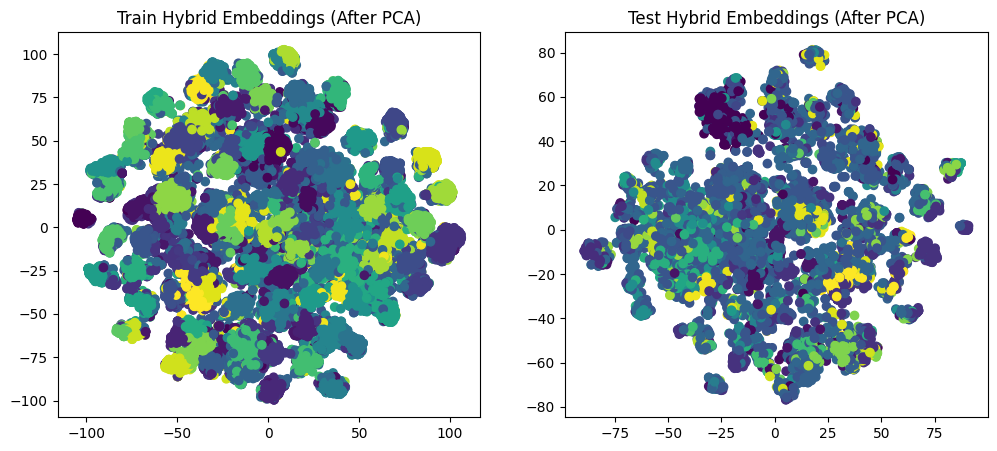

In [25]:
# visualize embeddings in 2D space using clustering labels for hybrid train and test sets
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
pca = PCA(n_components=50)
tsne = TSNE(n_components = 2,n_jobs=-1)
train_tsne_data = tsne.fit_transform(pca.fit_transform(train_embeddings_hybrid))
test_tsne_data = tsne.fit_transform(pca.fit_transform(test_embeddings_hybrid))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(train_tsne_data[:,0], train_tsne_data[:,1],c=hybrid_train_reduced_cluster_labels_)
plt.title('Train Hybrid Embeddings (After PCA)')
plt.subplot(1,2,2)
plt.scatter(test_tsne_data[:,0], test_tsne_data[:,1],c=hybrid_test_reduced_cluster_labels)
plt.title('Test Hybrid Embeddings (After PCA)')
plt.show()

In [28]:
# add back index column
index_train = np.zeros((train_embeddings_hybrid.shape[0],1))
index_test = np.zeros((test_embeddings_hybrid.shape[0],1))

for i in range(index_train.shape[0]):
  index_train[i,0] = i+1

for i in range(index_test.shape[0]):
  index_test[i,0] = i+1

train_indexed = np.hstack([index_train,train_embeddings_hybrid])
test_indexed = np.hstack([index_test,test_embeddings_hybrid])

print(train_indexed.shape)
print(test_indexed.shape)

(49984, 1255)
(9984, 1255)


In [29]:
# save hybrid embeddings and cluster centers
np.savetxt('embeddings_train_hybrid_reduced_70.csv',train_indexed,delimiter=',')
np.savetxt('embeddings_test_hybrid_reduced_70.csv',test_indexed,delimiter=',')

In [30]:
# save cluster centers and labels
np.savetxt('cluster_centers_train_hybrid_reduced_70.csv', hybrid_train_reduced_cluster_centers,delimiter=',')
np.savetxt('labels_train_hybrid_reduced_70.csv',hybrid_train_reduced_cluster_labels_,delimiter=',')
np.savetxt('labels_test_hybrid_reduced_70.csv',hybrid_test_reduced_cluster_labels,delimiter=',')

In [31]:
# copy files to drive
!cp 'embeddings_train_hybrid_reduced_70.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final'
!cp 'embeddings_test_hybrid_reduced_70.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final'
!cp 'cluster_centers_train_hybrid_reduced_70.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final'
!cp 'labels_train_hybrid_reduced_70.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final'
!cp 'labels_test_hybrid_reduced_70.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project Final'
